In [68]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFE

In [69]:
# Load data frame
df = pd.read_csv('data1.csv')

In [70]:
# Display data frame
df

Mouth_Open_mean  Mouth_Open_std  Mouth_Open_skew  Mouth_Open_median  \
0         -0.316932       -0.139323         0.520572                0.0   
1         -0.372296       -0.613061        -0.547291                0.0   
2         -0.372296       -0.613061        -0.547291                0.0   
3         -0.370426       -0.525913         5.275935                0.0   
4         -0.329409       -0.196029         0.666669                0.0   
..              ...             ...              ...                ...   
75        -0.065881        0.497312        -0.098430                0.0   
76        -0.372296       -0.613061        -0.547291                0.0   
77        -0.372296       -0.613061        -0.547291                0.0   
78        -0.372296       -0.613061        -0.547291                0.0   
79        -0.331304       -0.205336         0.694524                0.0   

    Mouth_Open_range  Mouth_Closed_mean  Mouth_Closed_std  Mouth_Closed_skew  \
0           0.941697           0.316932         -0.139323          -0.520572   
1          -1.061913           0.372296         -0.613061           0.547291   
2          -1.061913           0.372296         -0.613061           0.547291   
3           0.941697           0.370426         -0.525913          -5.275935   
4           0.941697           0.329409         -0.196029          -0.666669   
..               ...                ...               ...                ...   
75          0.941697           0.065881          0.497312           0.098430   
76         -1.061913           0.372296         -0.613061           0.547291   
77         -1.061913           0.372296         -0.613061           0.547291   
78         -1.061913           0.372296         -0.613061           0.547291   
79          0.941697           0.331304         -0.205336          -0.694524   

    Mouth_Closed_median  Mouth_Closed_range  ...  Right Eyebrow_Raised_skew  \
0                   0.0            0.941697  ...                  -0.257987   
1                   0.0           -1.061913  ...                  -0.257987   
2                   0.0           -1.061913  ...                  -0.257987   
3                   0.0            0.941697  ...                  -0.257987   
4                   0.0            0.941697  ...                  -0.257987   
..                  ...                 ...  ...                        ...   
75                  0.0            0.941697  ...                  -0.257987   
76                  0.0           -1.061913  ...                  -0.257987   
77                  0.0           -1.061913  ...                  -0.257987   
78                  0.0           -1.061913  ...                  -0.257987   
79                  0.0            0.941697  ...                  -0.257987   

    Right Eyebrow_Raised_median  Right Eyebrow_Raised_range  \
0                           0.0                   -0.333333   
1                           0.0                   -0.333333   
2                           0.0                   -0.333333   
3                           0.0                   -0.333333   
4                           0.0                   -0.333333   
..                          ...                         ...   
75                          0.0                   -0.333333   
76                          0.0                   -0.333333   
77                          0.0                   -0.333333   
78                          0.0                   -0.333333   
79                          0.0                   -0.333333   

    Right Eyebrow_Lowered_mean  Right Eyebrow_Lowered_std  \
0                    -0.358371                  -0.608323   
1                    -0.358371                  -0.608323   
2                    -0.358371                  -0.608323   
3                     1.397810                   2.939553   
4                    -0.358371                  -0.608323   
..                         ...                        ...   
75       

In [71]:
# Extract features by dropping target columns from the dataset
X = df.drop(['Expressiveness','Artificiality'], axis=1)  
# Extract target variable 'Artificiality' from the dataset
y = df['Artificiality'] 

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [72]:
# Pipeline setup for Logistic Regression with StandardScaler
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=100))
])

# Define cross-validation strategy
cv_strategy_lr = StratifiedKFold(n_splits=10)

# Define the parameter grid for hyperparameter tuning
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1]
}

# Initialize GridSearchCV with the pipeline and the parameter grid
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=cv_strategy_lr, scoring='f1', verbose=1)

# Fit GridSearchCV to find the best hyperparameters
grid_search_lr.fit(X_train, y_train)

# Extract the best hyperparameter value for C and update the pipeline
best_C_lr = grid_search_lr.best_params_['classifier__C']
print(f"Best 'C' value: {best_C_lr}")
pipeline_lr.set_params(classifier__C=best_C_lr)

# Initialize RFECV with the updated pipeline's classifier
selector_lr = RFECV(
    estimator=pipeline_lr.named_steps['classifier'],
    step=1,
    cv=cv_strategy_lr,
    scoring='f1',
    min_features_to_select=1
)

# Fit RFECV
selector_lr.fit(X_train, y_train)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15, 4))
plt.title("Impact of Feature Selection on Cross-Validation F1 Score in LR Models")
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (F1 score)")
plt.plot(range(1, len(selector_lr.grid_scores_) + 1), selector_lr.grid_scores_)
plt.xticks(range(1, len(selector_lr.grid_scores_) + 1, 2))
plt.show()

# Determine the optimal features
optimal_features_lr = [f for f, s in zip(X_train.columns, selector_lr.support_) if s]

# Fit the pipeline on the training data using optimal features
pipeline_lr.fit(X_train[optimal_features_lr], y_train)

# Plot the LR coefficients for the selected features
if hasattr(pipeline_lr.named_steps['classifier'], "coef_"):
    coefficients = pipeline_lr.named_steps['classifier'].coef_[0]
    indices = np.argsort(coefficients)[::-1]
    names = [optimal_features_lr[i] for i in indices]
    
    plt.figure(figsize=(15, 5))
    plt.title("LR Coefficients of Selected Features")
    bars = plt.bar(range(len(indices)), coefficients[indices])
    plt.xticks(range(len(indices)), names, rotation=90)
    plt.axhline(0, color='grey', linewidth=0.8, linestyle='--')
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(bar.get_height(), 2),
                 ha='center', va='bottom' if bar.get_height() > 0 else 'top')
    plt.show()

# Make predictions using the pipeline with optimal features
y_train_pred_lr = pipeline_lr.predict(X_train[optimal_features_lr])
y_test_pred_lr = pipeline_lr.predict(X_test[optimal_features_lr])

# Evaluation
f1_train_lr = f1_score(y_train, y_train_pred_lr, average='binary')
f1_test_lr = f1_score(y_test, y_test_pred_lr, average='binary')

# Output final F1 scores
print(f"Final F1 Score on training data with {len(optimal_features_lr)} features: {f1_train_lr}")
print(f"Final F1 Score on test data with {len(optimal_features_lr)} features: {f1_test_lr}")

# Output classification reports
print("Classification Report for Training Data (Logistic Regression):")
print(classification_report(y_train, y_train_pred_lr))
print("Classification Report for Test Data (Logistic Regression):")
print(classification_report(y_test, y_test_pred_lr))

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best 'C' value: 1


/Users/femkeverseveld/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Final F1 Score on training data with 18 features: 0.7692307692307692
Final F1 Score on test data with 18 features: 0.7058823529411765
Classification Report for Training Data (Logistic Regression):
              precision    recall  f1-score   support

           1       0.76      0.78      0.77        32
           2       0.77      0.75      0.76        32

    accuracy                           0.77        64
   macro avg       0.77      0.77      0.77        64
weighted avg       0.77      0.77      0.77        64

Classification Report for Test Data (Logistic Regression):
              precision    recall  f1-score   support

           1       0.67      0.75      0.71         8
           2       0.71      0.62      0.67         8

    accuracy                           0.69        16
   macro avg       0.69      0.69      0.69        16
weighted avg       0.69      0.69      0.69        16



Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best 'C' value for SVC: 1


/Users/femkeverseveld/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


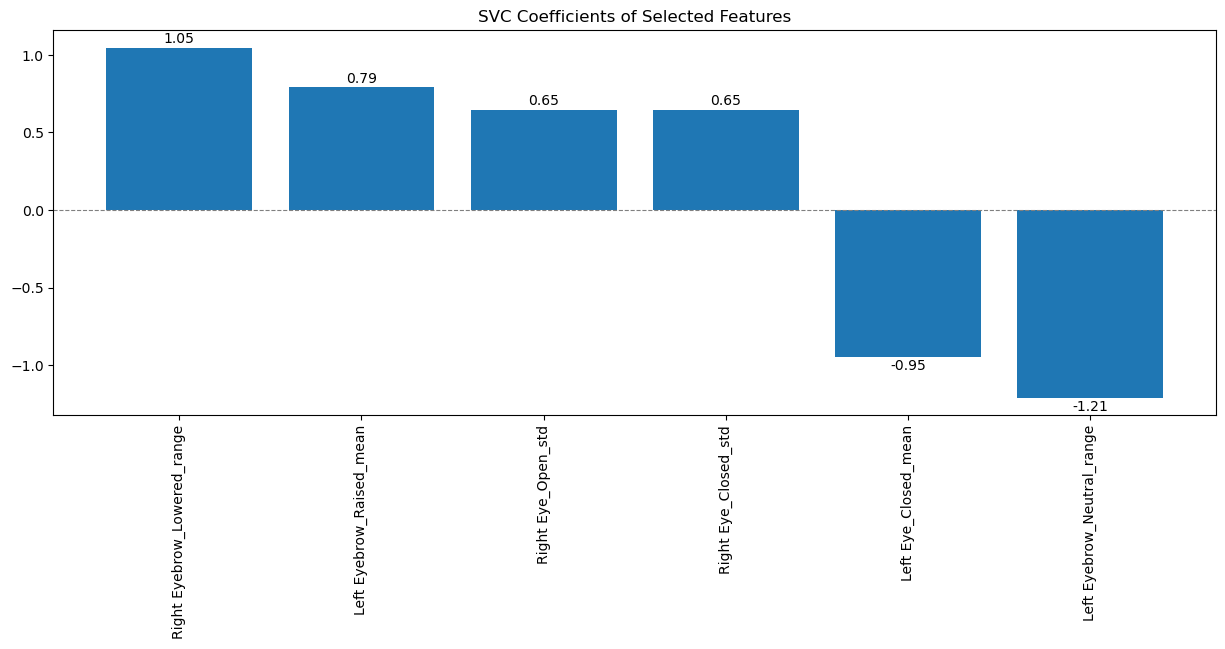

Final F1 Score on training data with 6 features: 0.7246376811594203
Final F1 Score on test data with 6 features: 0.631578947368421
Classification Report for Training Data (SVC):
              precision    recall  f1-score   support

           1       0.68      0.78      0.72        32
           2       0.74      0.62      0.68        32

    accuracy                           0.70        64
   macro avg       0.71      0.70      0.70        64
weighted avg       0.71      0.70      0.70        64

Classification Report for Test Data (SVC):
              precision    recall  f1-score   support

           1       0.55      0.75      0.63         8
           2       0.60      0.38      0.46         8

    accuracy                           0.56        16
   macro avg       0.57      0.56      0.55        16
weighted avg       0.57      0.56      0.55        16



In [73]:
# Pipeline setup for SVC with StandardScaler
pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(kernel='linear', random_state=42, probability=False))
])

# Define cross-validation strategy
cv_strategy_svc = StratifiedKFold(n_splits=10)

# Define the parameter grid for hyperparameter tuning
param_grid_svc = {
    'classifier__C': [0.01, 0.1, 1]
}

# Initialize GridSearchCV with the pipeline and the parameter grid
grid_search_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=cv_strategy_svc, scoring='f1', verbose=1, n_jobs=-1)

# Fit GridSearchCV to find the best hyperparameters
grid_search_svc.fit(X_train, y_train)

# Extract the best hyperparameter value for C and update the pipeline
best_C_svc = grid_search_svc.best_params_['classifier__C']
print(f"Best 'C' value for SVC: {best_C_svc}")
pipeline_svc.set_params(classifier__C=best_C_svc)

# Initialize RFECV with the updated pipeline's classifier
selector_svc = RFECV(
    estimator=pipeline_svc.named_steps['classifier'],
    step=1,
    cv=cv_strategy_svc,
    scoring='f1',
    min_features_to_select=1
)

# Fit RFECV
selector_svc.fit(X_train, y_train)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15, 4))
plt.title("Impact of Feature Selection on Cross-Validation F1 Score in SVC Models")
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (F1 score)")
plt.plot(range(1, len(selector_svc.grid_scores_) + 1), selector_svc.grid_scores_)
plt.xticks(range(1, len(selector_svc.grid_scores_) + 1, 2))
plt.show()

# Determine the optimal features
optimal_features_svc = [f for f, s in zip(X_train.columns, selector_svc.support_) if s]

# Fit the pipeline on the optimal features
pipeline_svc.fit(X_train[optimal_features_svc], y_train)

# Plot the SVC coefficients for the selected features
if hasattr(pipeline_svc.named_steps['classifier'], "coef_"):
    coefficients = pipeline_svc.named_steps['classifier'].coef_[0]
    indices = np.argsort(coefficients)[::-1]
    names = [optimal_features_svc[i] for i in indices]
    
    plt.figure(figsize=(15, 5))
    plt.title("SVC Coefficients of Selected Features")
    bars = plt.bar(range(len(indices)), coefficients[indices])
    plt.xticks(range(len(indices)), names, rotation=90)

    # Calculate the offset as a fraction of the y-axis range
    y_offset = (plt.ylim()[1] - plt.ylim()[0]) * 0.005

    # Draw a horizontal line at zero
    plt.axhline(0, color='grey', linewidth=0.8, linestyle='--') 

    # Annotate the bars with the coefficient values
    for bar in bars:
        yval = bar.get_height()
        if yval >= 0:  # if bar is positive, place text above the bar
            plt.text(bar.get_x() + bar.get_width()/2, yval + y_offset, round(yval, 2), va='bottom', ha='center')
        else:  # if bar is negative, place text below the bar
            plt.text(bar.get_x() + bar.get_width()/2, yval - y_offset, round(yval, 2), va='top', ha='center')

plt.show()

# Make predictions using the pipeline
y_train_pred_svc = pipeline_svc.predict(X_train[optimal_features_svc])
y_test_pred_svc = pipeline_svc.predict(X_test[optimal_features_svc])

# Evaluation
f1_train_svc = f1_score(y_train, y_train_pred_svc, average='binary')
f1_test_svc = f1_score(y_test, y_test_pred_svc, average='binary')

# Output final F1 scores
print(f"Final F1 Score on training data with {len(optimal_features_svc)} features: {f1_train_svc}")
print(f"Final F1 Score on test data with {len(optimal_features_svc)} features: {f1_test_svc}")

# Output classification reports
print("Classification Report for Training Data (SVC):")
print(classification_report(y_train, y_train_pred_svc))
print("Classification Report for Test Data (SVC):")
print(classification_report(y_test, y_test_pred_svc))

                       Feature  Coefficient_LR  Coefficient_SVC  Difference  \
4  Right Eyebrow_Lowered_range        0.425403         1.047159   -0.621756   
0         Left Eye_Closed_mean       -0.481755        -0.949925    0.468169   
1     Left Eyebrow_Raised_mean        0.671474         0.790682   -0.119208   
3           Right Eye_Open_std        0.587452         0.645949   -0.058497   
2         Right Eye_Closed_std        0.587452         0.645949   -0.058497   

   Abs_Difference  
4        0.621756  
0        0.468169  
1        0.119208  
3        0.058497  
2        0.058497  


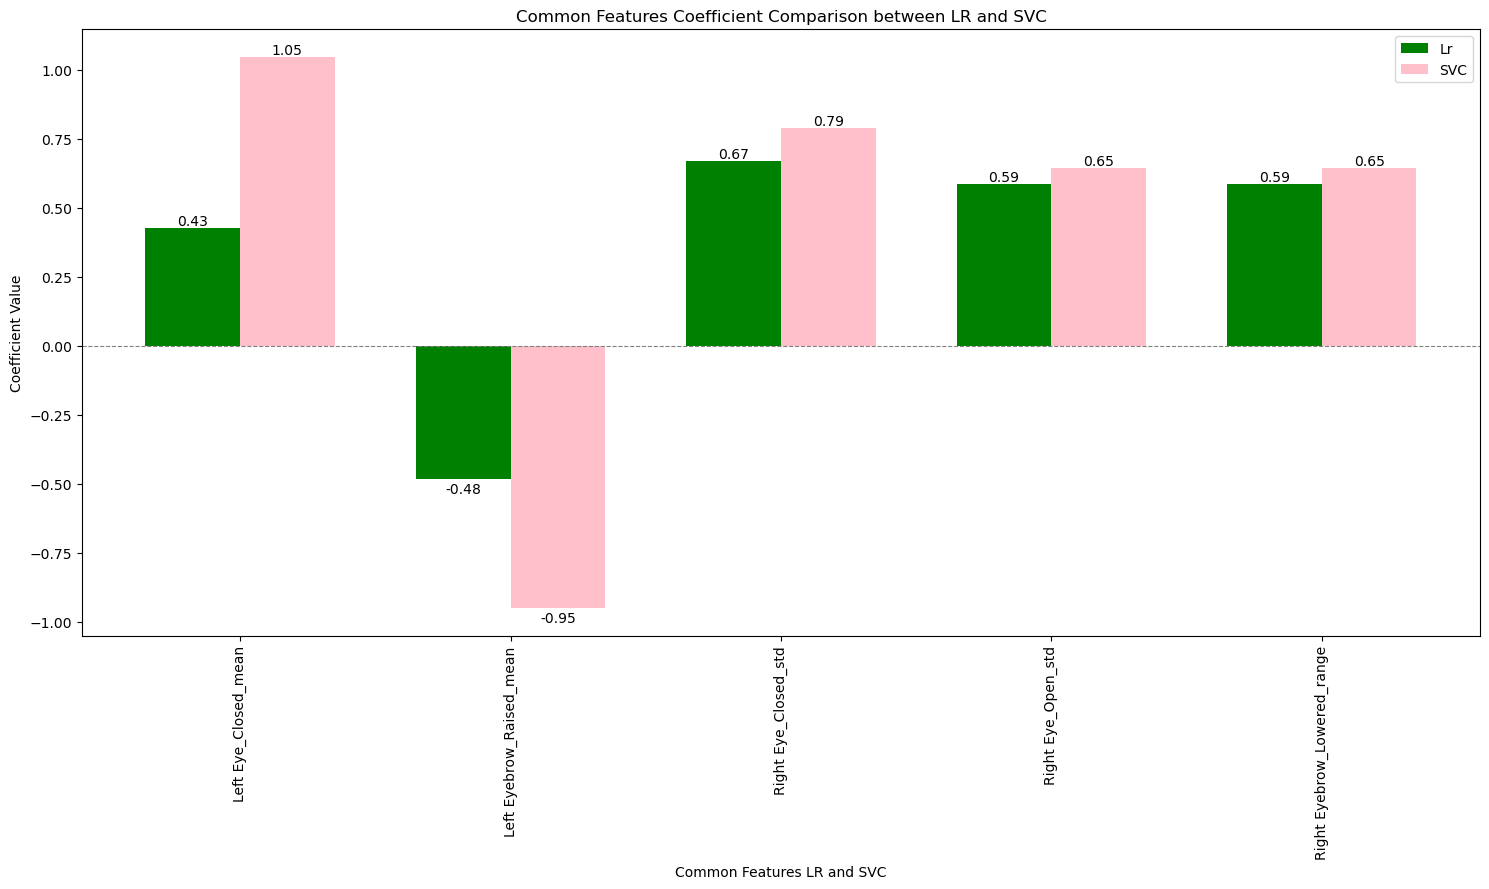

In [80]:
# Aligning the feature sets if necessary
common_features = sorted(list(set(optimal_features_lr) & set(optimal_features_svc)))

# Extract coefficients for the common features in both models
coefficients_lr = [pipeline_lr.named_steps['classifier'].coef_[0][optimal_features_lr.index(f)] for f in common_features]
coefficients_svc = [pipeline_svc.named_steps['classifier'].coef_[0][optimal_features_svc.index(f)] for f in common_features]

# Create a DataFrame with the coefficients
coef_comparison_df = pd.DataFrame({
    'Feature': common_features,
    'Coefficient_LR': coefficients_lr,
    'Coefficient_SVC': coefficients_svc
})

# Calculating the difference in coefficients for each feature
coef_comparison_df['Difference'] = coef_comparison_df['Coefficient_LR'] - coef_comparison_df['Coefficient_SVC']

# Sort the DataFrame by the absolute difference in descending order to see the features with the most discrepancy
coef_comparison_df['Abs_Difference'] = coef_comparison_df['Difference'].abs()
coef_comparison_df = coef_comparison_df.sort_values(by='Abs_Difference', ascending=False)

# Display the DataFrame
print(coef_comparison_df)

# Plot the coefficients for comparison
indices = np.arange(len(common_features))
bar_width = 0.35

plt.figure(figsize=(15, 9))
plt.title("Common Features Coefficient Comparison between LR and SVC")

lr_bars = plt.bar(indices, coef_comparison_df['Coefficient_LR'], bar_width, label='Lr', color='green')
svc_bars = plt.bar(indices + bar_width, coef_comparison_df['Coefficient_SVC'], bar_width, label='SVC', color='pink')

# Adding a grey line at y=0
plt.axhline(0, color='grey', linewidth=0.8, linestyle='--')

# Annotating the LR bars
for bar in lr_bars:
    height = bar.get_height()
    offset = 0.01  # Smaller offset for better control
    plt.text(bar.get_x() + bar.get_width() / 2, 
             height if height > 0 else height - offset,
             f'{height:.2f}', 
             ha='center', 
             va='bottom' if height > 0 else 'top',
             color='black')

# Annotating the SVC bars
for bar in svc_bars:
    height = bar.get_height()
    offset = 0.01  # Same as for LR bars
    plt.text(bar.get_x() + bar.get_width() / 2, 
             height if height > 0 else height - offset,
             f'{height:.2f}', 
             ha='center', 
             va='bottom' if height > 0 else 'top',
             color='black')

plt.xlabel('Common Features LR and SVC')
plt.ylabel('Coefficient Value')
plt.xticks(indices + bar_width / 2, common_features, rotation=90)
plt.legend()

plt.tight_layout()
plt.show()